In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from scipy.stats import mode

# Load dataset
data = pd.read_csv("mood_music_dataset.csv")

# Quick check
print(data.head())
print("\nMissing values per column:\n", data.isna().sum())

# Fill missing values
data["Heart Rate"].fillna(data["Heart Rate"].mode()[0], inplace=True)
data["Skin Temperature"].fillna(data["Skin Temperature"].median(), inplace=True)
data["Blink Rate"].fillna(data["Blink Rate"].mode()[0], inplace=True)

print("Missing values after fill:\n", data.isna().sum())


   Heart Rate  Skin Temperature  Blink Rate Time of Day      Mood      Score
0   72.849293         36.722123   19.032228       Night     Happy   8.003257
1   69.546081         35.626662   11.634197     Morning       Sad  24.232981
2   97.983918         38.022626   34.686636   Afternoon  Stressed  77.367935
3   72.682425         36.717484   20.984903     Evening     Happy  52.868585
4   70.316874         35.949165   10.210935   Afternoon       Sad  92.796906

Missing values per column:
 Heart Rate          74
Skin Temperature    75
Blink Rate          75
Time of Day          0
Mood                 0
Score                0
dtype: int64
Missing values after fill:
 Heart Rate          0
Skin Temperature    0
Blink Rate          0
Time of Day         0
Mood                0
Score               0
dtype: int64


C:\Users\C Sutharsan\AppData\Local\Temp\ipykernel_12120\464552926.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Heart Rate"].fillna(data["Heart Rate"].mode()[0], inplace=True)
C:\Users\C Sutharsan\AppData\Local\Temp\ipykernel_12120\464552926.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [3]:
def detect_and_print_outliers(df, cols):
    for col in cols:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)][[col]]
        print(f"\nColumn: {col}")
        print("Lower bound:", lower, "Upper bound:", upper)
        print(f"Outlier Count: {outliers.shape[0]}")
        if not outliers.empty:
            print(outliers.head())

numeric_cols = ["Heart Rate", "Skin Temperature", "Blink Rate", "Score"]
detect_and_print_outliers(data, numeric_cols)


Column: Heart Rate
Lower bound: 38.89034178607855 Upper bound: 117.1934641313704
Outlier Count: 3
     Heart Rate
601  121.846742
769  125.619470
888  119.100486

Column: Skin Temperature
Lower bound: 35.07186626523236 Upper bound: 38.25516361050248
Outlier Count: 23
     Skin Temperature
143         38.475571
192         38.882990
196         38.639201
253         38.283898
307         38.367416

Column: Blink Rate
Lower bound: -5.1486700888289025 Upper bound: 44.38026291957972
Outlier Count: 85
    Blink Rate
10   49.493592
13   49.493592
23   49.493592
30   49.493592
63   49.493592

Column: Score
Lower bound: -52.652694420715406 Upper bound: 151.24838787320638
Outlier Count: 0


In [5]:
#Feature engineering
# Categorize heart rate
def categorize_heart_rate(hr):
    if hr < 60:
        return "Low"
    elif 60 <= hr <= 100:
        return "Medium"
    return "High"

# Categorize blink rate
def categorize_blink_rate(br):
    return "High" if br > 25 else "Good"

# Apply
data["Heart_rate_category"] = data["Heart Rate"].map(categorize_heart_rate)
data["Blink_rate_category"] = data["Blink Rate"].map(categorize_blink_rate)


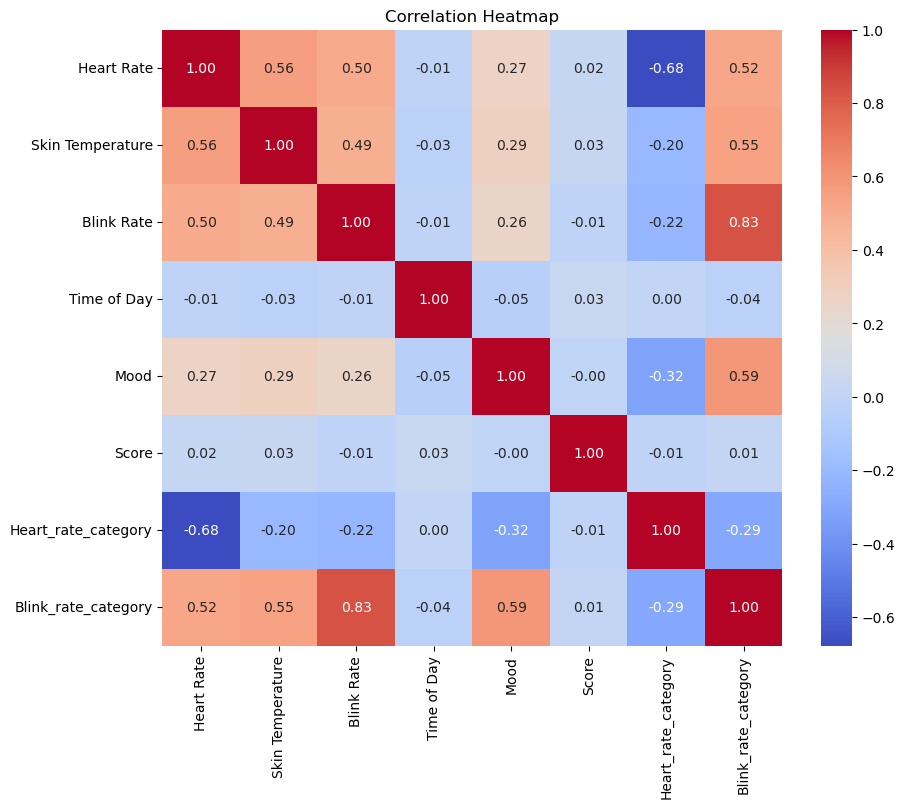

In [7]:
# Encode categorical columns
categorical_cols = ["Time of Day", "Mood", "Heart_rate_category", "Blink_rate_category"]

mood_encoder = LabelEncoder()
data["Mood"] = mood_encoder.fit_transform(data["Mood"])

# Save encoder for later
joblib.dump(mood_encoder, "mood_encoder.pkl")

# Encode other categorical cols
for col in [c for c in categorical_cols if c != "Mood"]:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [11]:
# Drop unused columns
X = data.drop(["Mood", "Heart_rate_category", "Blink_rate_category"], axis=1)
y = data["Mood"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

model = XGBClassifier(n_estimators=200, random_state=42, eval_metric="mlogloss")

pipe = Pipeline([("model", model)])
pipe.fit(X_train, y_train)

# Save trained model
joblib.dump(pipe, "XGBoost_advanced_classifier.pkl")

preds = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds))
print("Precision (macro):", precision_score(y_test, preds, average="macro"))
print("Recall (macro):", recall_score(y_test, preds, average="macro"))
print("F1 Score (macro):", f1_score(y_test, preds, average="macro"))

print("\nClassification Report:\n", classification_report(y_test, preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


Train shape: (1200, 5) Test shape: (300, 5)
Accuracy: 0.8433333333333334
Precision (macro): 0.8474872305208323
Recall (macro): 0.8433333333333334
F1 Score (macro): 0.8449845120541728

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92        75
           1       0.72      0.73      0.73        75
           2       0.75      0.80      0.77        75
           3       0.97      0.95      0.96        75

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.84       300
weighted avg       0.85      0.84      0.84       300

Confusion Matrix:
 [[67  6  0  2]
 [ 0 55 20  0]
 [ 0 15 60  0]
 [ 4  0  0 71]]


In [13]:
# Load trained model & encoder
model = joblib.load("XGBoost_advanced_classifier.pkl")
mood_encoder = joblib.load("mood_encoder.pkl")

# Automatically align dictionary with encoder classes
mood_to_song = {
    mood: song for mood, song in zip(
        mood_encoder.classes_,
        ["Anirudh songs 🎉",
         "Calm Acoustic or Soft Piano U1 drugs 🎶",
         "Healing music Endrendrum Raja 🤘",
         "Lo-fi or Jazz to chill out Periya Bhai ☕"]
    )
}

# Time encoding
time_mapping = {"Morning": 0, "Afternoon": 1, "Evening": 2, "Dinner": 3}

# User input
print("Enter the following details to predict your mood:")
heart_rate = float(input("💓 Heart Rate (bpm): "))
blink_rate = float(input("👀 Blink Rate (per min): "))
temperature = float(input("🌡️ Body Temperature (°C): "))
score = float(input("⭐ Score (0-10): "))
time_input = input("⏰ Time of Day (Morning/Afternoon/Evening/Dinner): ")

time_of_day = time_mapping.get(time_input.capitalize(), 0)

# Features
features = np.array([[heart_rate, blink_rate, temperature, score, time_of_day]])

# Predict
pred_numeric = model.predict(features)[0]
pred_label = mood_encoder.inverse_transform([pred_numeric])[0]

# Song recommendation
song_suggestion = mood_to_song.get(pred_label, "Any genre you enjoy 🎵")

print("\n==============================")
print(f"Predicted Mood: {pred_label}")
print(f"Recommended Songs: {song_suggestion}")
print("==============================")


Enter the following details to predict your mood:


💓 Heart Rate (bpm):  72
👀 Blink Rate (per min):  12
🌡️ Body Temperature (°C):  38.4
⭐ Score (0-10):  8
⏰ Time of Day (Morning/Afternoon/Evening/Dinner):  dinner



Predicted Mood: Sad
Recommended Songs: Healing music Endrendrum Raja 🤘
